### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [3]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
# 印出網路結構
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxP

In [7]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [8]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

: 7.6927e-04

Epoch 00032: val_loss improved from 0.00079 to 0.00077, saving model to best_weights.h5
Epoch 33/150
1712/1712 [==============================] - 1s 704us/step - loss: 2.2901e-04 - val_loss: 7.6735e-04

Epoch 00033: val_loss improved from 0.00077 to 0.00077, saving model to best_weights.h5
Epoch 34/150
1712/1712 [==============================] - 1s 808us/step - loss: 2.2420e-04 - val_loss: 8.2416e-04

Epoch 00034: val_loss did not improve from 0.00077
Epoch 35/150
1712/1712 [==============================] - 1s 677us/step - loss: 2.2419e-04 - val_loss: 7.8103e-04

Epoch 00035: val_loss did not improve from 0.00077
Epoch 36/150
1712/1712 [==============================] - 1s 501us/step - loss: 2.2017e-04 - val_loss: 7.6087e-04

Epoch 00036: val_loss improved from 0.00077 to 0.00076, saving model to best_weights.h5
Epoch 37/150
1712/1712 [==============================] - 1s 472us/step - loss: 2.1251e-04 - val_loss: 7.6901e-04

Epoch 00037: val_loss did not improve from 0.

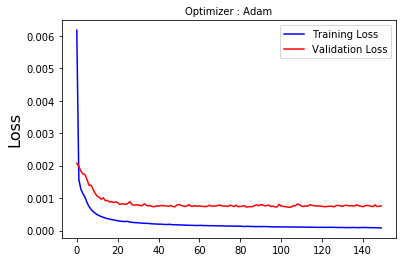

In [9]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [10]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [11]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

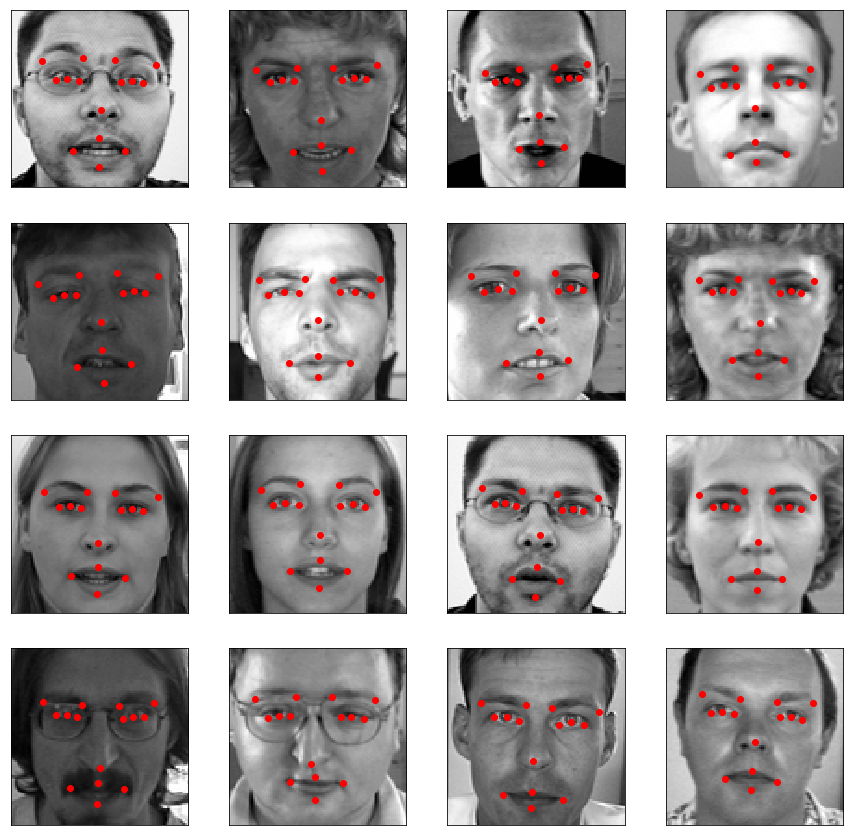

In [12]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [13]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
# Your code

In [16]:
import imgaug.augmenters as iaa
# 讀取資料集以及做前處理的函數
def load_data_augment(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 
    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    aug = iaa.Fliplr(0.5)
    imgs_aug = aug.augment_images(imgs)
    imgs = np.vstack([imgs, imgs_aug])

    # 提取坐標的部分
    points = data[data.columns[:-1]].values
    # 轉換為 float
    points = points.astype(np.float32)
    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5

    points_augment = points_train.copy()  
    for i in range(0,points_augment.shape[1],2):
        points_augment[:,i]=-points_augment[:,i]
    points = np.vstack([points, points_augment])

    return imgs, points

In [17]:
imgs_train2, points_train2 = load_data_augment('training.csv')
checkpoint2 = ModelCheckpoint('best_weights2.h5', verbose=1, save_best_only=True)
hist2 = History()
hist_model2 = model_with_augment.fit(imgs_train2.reshape(-1, 96, 96, 1), 
                       points_train2, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint2, hist2],
                       shuffle=True, epochs=150, verbose=1)

4: val_loss did not improve from 0.02722
Epoch 25/150
3424/3424 [==============================] - 1s 385us/step - loss: 0.0098 - val_loss: 0.0630

Epoch 00025: val_loss did not improve from 0.02722
Epoch 26/150
3424/3424 [==============================] - 1s 382us/step - loss: 0.0097 - val_loss: 0.0647

Epoch 00026: val_loss did not improve from 0.02722
Epoch 27/150
3424/3424 [==============================] - 1s 316us/step - loss: 0.0096 - val_loss: 0.0664

Epoch 00027: val_loss did not improve from 0.02722
Epoch 28/150
3424/3424 [==============================] - 1s 356us/step - loss: 0.0096 - val_loss: 0.0582

Epoch 00028: val_loss did not improve from 0.02722
Epoch 29/150
3424/3424 [==============================] - 1s 394us/step - loss: 0.0096 - val_loss: 0.0688

Epoch 00029: val_loss did not improve from 0.02722
Epoch 30/150
3424/3424 [==============================] - 1s 356us/step - loss: 0.0095 - val_loss: 0.0550

Epoch 00030: val_loss did not improve from 0.02722
Epoch 31/15

In [18]:
# save the model weights
model_with_augment.save_weights('weights2.h5')
# save the model
model_with_augment.save('model2.h5')

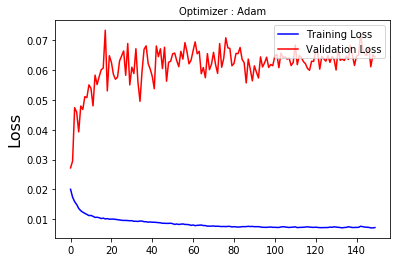

In [19]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model2.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model2.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')